In [1]:
package = "../../"
import sys
import os
package = os.path.abspath(package)
sys.path.append(package)


In [3]:
import numpy as np
import torch
import logging
import sys
import os
import pytest
import glob
from src.trainer.flux_kontext_trainer import FluxKontextLoraTrainer
from src.data.config import load_config_from_yaml
from src.data.dataset import loader
from diffusers.utils import load_image

In [4]:
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(name)s: %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)],
    force=True,  # 关键：覆盖已有配置
)
logger = logging.getLogger(__name__)
logger.info("it works")


2025-09-17 17:41:09,048 | INFO | __main__: it works


# 1. Flux Kontext

# 1.1 Single control

## 1.1.1 Without Lora

In [5]:
IMAGE_PATH='https://n.sinaimg.cn/ent/transform/775/w630h945/20201127/cee0-kentcvx8062290.jpg'
prompt='change the hair color to dark blue'
prompt_image = load_image(IMAGE_PATH)

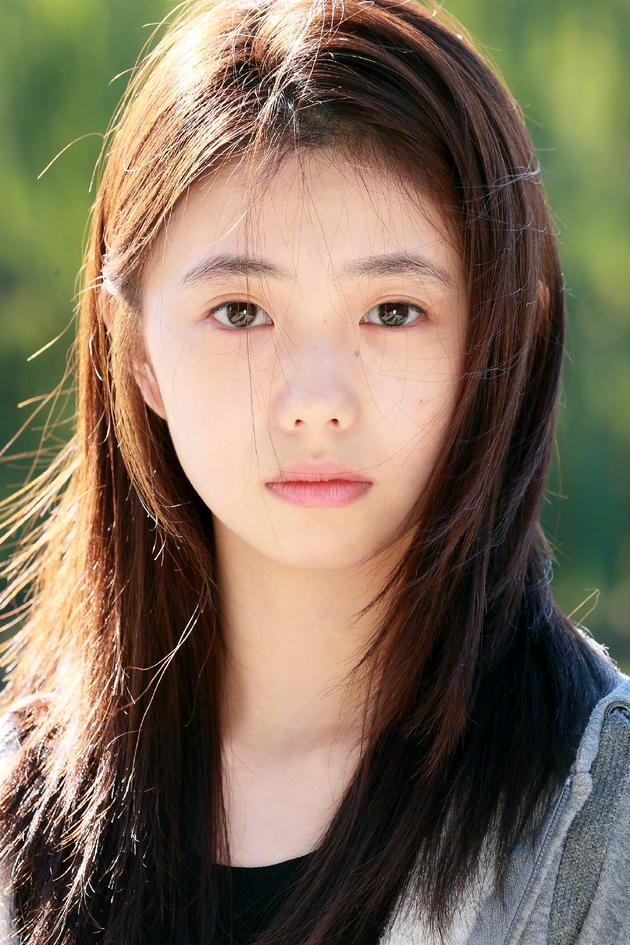

In [6]:
prompt_image

In [7]:
prompt_image.size

(630, 945)

In [8]:
config="../../tests/test_configs/test_example_fluxkontext_fp16.yaml"
config = load_config_from_yaml(config)
trainer = FluxKontextLoraTrainer(config)

2025-09-17 17:41:19,557 | INFO | src.trainer.base_trainer: Batch Size: 16
2025-09-17 17:41:19,558 | INFO | src.trainer.base_trainer: Use Cache: True
2025-09-17 17:41:19,577 | INFO | root: ImageProcessor initialized with target_size: (832, 576)controls_size: [(832, 576)]


In [9]:
config

Config(trainer=<TrainerKind.FluxKontext: 'FluxKontext'>, resume=None, mode=<TrMode.predict: 'predict'>, model=ModelConfig(pretrained_model_name_or_path='black-forest-labs/FLUX.1-Kontext-dev', pretrained_embeddings=None, lora=LoraConfig(r=16, lora_alpha=16, init_lora_weights='gaussian', target_modules=['to_k', 'to_q', 'to_v', 'to_out.0'], pretrained_weight=None, adapter_name='lora_edit'), quantize=False), data=DataConfig(class_path='src.data.dataset.ImageDataset', init_args=DatasetInitArgs(dataset_path=[{'split': 'train', 'repo_id': 'TsienDragon/face_segmentation_20'}], caption_dropout_rate=0.0, prompt_image_dropout_rate=0.0, cache_dir='/tmp/image_edit_lora/fp16/cache', use_cache=True, use_edit_mask=True, selected_control_indexes=[1], prompt_empty_drop_keys=['prompt_embeds', 'pooled_prompt_embeds'], processor=ImageProcessorConfig(class_path='src.data.preprocess.ImageProcessor', init_args=ImageProcessorInitArgs(process_type='center_crop', resize_mode='bilinear', target_size=[832, 576], c

In [10]:
out = trainer.predict(
    prompt_image=prompt_image,
    prompt=prompt,
    num_inference_steps=20,
    true_cfg_scale=1.0,
    negative_prompt="",
    weight_dtype=torch.bfloat16,
    height=945,
    width=630,
    output_type='pil'
)
# save_path = 'tests/test_flux_kontext_trainer.png'
# save_path = os.path.abspath(save_path)

2025-09-17 17:41:21,493 | INFO | root: Loading model...
2025-09-17 17:41:21,494 | INFO | root: Loading FluxKontextPipeline and separating components...
2025-09-17 17:41:21,496 | INFO | src.models.flux_kontext_loader: Loading Flux Kontext VAE from black-forest-labs/FLUX.1-Kontext-dev
2025-09-17 17:41:22,810 | INFO | src.models.flux_kontext_loader: Loading Flux Kontext CLIP encoder from black-forest-labs/FLUX.1-Kontext-dev
2025-09-17 17:41:23,783 | INFO | src.models.flux_kontext_loader: Loading Flux Kontext T5 encoder from black-forest-labs/FLUX.1-Kontext-dev


Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00, 11.92it/s]

2025-09-17 17:41:25,614 | INFO | src.models.flux_kontext_loader: Loading Flux Kontext tokenizers from black-forest-labs/FLUX.1-Kontext-dev



You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


2025-09-17 17:41:27,039 | INFO | src.models.flux_kontext_loader: Loading Flux Kontext scheduler from black-forest-labs/FLUX.1-Kontext-dev


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  6.86it/s]


2025-09-17 17:41:28,623 | INFO | src.models.flux_kontext_loader: Successfully loaded Flux Kontext scheduler
2025-09-17 17:41:28,632 | INFO | root: Components loaded successfully. VAE scale factor: 8
2025-09-17 17:41:52,184 | INFO | root: setup_model_device_train_mode done


                                    Model Summary: model                                    
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Section     ┃ Metric                              ┃ Value                                ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Parameters  │ Total                               │ 11.90B                               │
│ Parameters  │ Trainable                           │ 0                                    │
│ Parameters  │ Trainable %                         │ 0.00%                                │
│ Parameters  │ Memory (total)                      │ 22.17 GB                             │
│ Parameters  │ Memory (trainable)                  │ 0 B                                  │
│ Modules     │ Total                               │ 1278                                 │
│ Modules     │ Leaf                                │ 948                                  │
│ Modules     │ Parameterized                       │ 656                                  │
│ Transformer │ Attention blocks (total/self/cross) │ 57/57/0                              │
│ Transformer │ Heads (hist)                        │ 24×57                                │
│ Transformer │ Attn hidden dim (hist)              │ 3072×57                              │
│ Transformer │ Norms                               │ LayerNorm×115, RMSNorm×152           │
│ Transformer │ FeedForward blocks                  │ 140                                  │
│ LoRA        │ Blocks                              │ 0                                    │
│ LoRA        │ Parameters                          │ 0                                    │
│ LoRA        │ Params % of total                   │ 0.00%                                │
│ LoRA        │ Ranks (hist)                        │                                      │
│ LoRA        │ Rank min/max                        │                                      │
│ DTypes      │ dtype                               │ params(total/train) | % | mem(total) │
│ DTypes      │ bf16                                │ 11.90B/0 | 100.00% | 22.17 GB        │
└─────────────┴─────────────────────────────────────┴──────────────────────────────────────┘

2025-09-17 17:41:52,281 | INFO | root: setup_predict done
2025-09-17 17:41:52,282 | INFO | root: Start predict
2025-09-17 17:41:52,282 | INFO | root: image size format [H,W]
2025-09-17 17:41:52,306 | INFO | root: ##################################################
2025-09-17 17:41:52,307 | INFO | root: image shapes for controls: None
2025-09-17 17:41:52,308 | INFO | root: image shape for target: [944, 624]
data keys dict_keys(['control', 'prompt', 'n_controls', 'negative_prompt', 'num_inference_steps', 'height', 'width', 'true_cfg_scale', 'guidance'])
control <class 'torch.Tensor'>
prompt <class 'list'>
n_controls <class 'int'>
negative_prompt <class 'list'>
num_inference_steps <class 'int'>
height <class 'int'>
width <class 'int'>
true_cfg_scale <class 'float'>
guidance <class 'float'>
calculate shift 2301 256 4096 0.5 1.15


Flux Kontext Generation: 100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


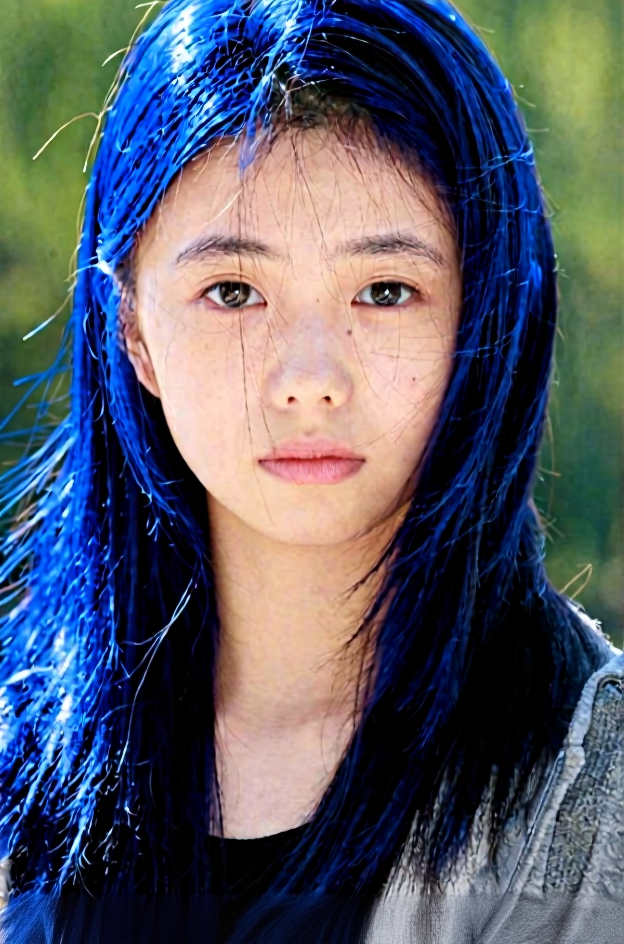

In [11]:
out[0]

## 1.1.2 With Lora Pretrained Weights

In [12]:
LORA_WEIGHT='/raid/lilong/data/experiment/flux-kontext-face_seg_lora_fp16/face_segmentation_lora/v2/checkpoint-199-1000/model.safetensors'
# LORA_WEIGHT='TsienDragon/qwen-image-edit-lora-face-segmentation'


In [13]:
config="../../tests/test_configs/test_example_fluxkontext_fp16.yaml"
config = load_config_from_yaml(config)

config.model.lora.pretrained_weight = LORA_WEIGHT
trainer = FluxKontextLoraTrainer(config)


2025-09-17 17:42:11,192 | INFO | src.trainer.base_trainer: Batch Size: 16
2025-09-17 17:42:11,193 | INFO | src.trainer.base_trainer: Use Cache: True
2025-09-17 17:42:11,194 | INFO | root: ImageProcessor initialized with target_size: (832, 576)controls_size: [(832, 576)]


In [14]:
trainer = FluxKontextLoraTrainer(config)


2025-09-17 17:42:12,802 | INFO | src.trainer.base_trainer: Batch Size: 16
2025-09-17 17:42:12,803 | INFO | src.trainer.base_trainer: Use Cache: True
2025-09-17 17:42:12,803 | INFO | root: ImageProcessor initialized with target_size: (832, 576)controls_size: [(832, 576)]


In [15]:
IMAGE_PATH='https://n.sinaimg.cn/ent/transform/775/w630h945/20201127/cee0-kentcvx8062290.jpg'
prompt='change the image from the face to the face segmentation mask'
prompt_image = load_image(IMAGE_PATH)


In [16]:
prompt_image.size

(630, 945)

In [17]:

out = trainer.predict(
    prompt_image=prompt_image,
    prompt=prompt,
    num_inference_steps=20,
    true_cfg_scale=1.0,
    negative_prompt="",
    weight_dtype=torch.bfloat16,
    height=945,
    width=630,
    output_type='pil'
)
# save_path = 'tests/test_flux_kontext_trainer.png'
# save_path = os.path.abspath(save_path)

2025-09-17 17:42:19,154 | INFO | root: Loading model...
2025-09-17 17:42:19,154 | INFO | root: Loading FluxKontextPipeline and separating components...
2025-09-17 17:42:19,155 | INFO | src.models.flux_kontext_loader: Loading Flux Kontext VAE from black-forest-labs/FLUX.1-Kontext-dev
2025-09-17 17:42:20,052 | INFO | src.models.flux_kontext_loader: Loading Flux Kontext CLIP encoder from black-forest-labs/FLUX.1-Kontext-dev
2025-09-17 17:42:21,071 | INFO | src.models.flux_kontext_loader: Loading Flux Kontext T5 encoder from black-forest-labs/FLUX.1-Kontext-dev


Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00, 16.06it/s]


2025-09-17 17:42:22,833 | INFO | src.models.flux_kontext_loader: Loading Flux Kontext tokenizers from black-forest-labs/FLUX.1-Kontext-dev
2025-09-17 17:42:24,294 | INFO | src.models.flux_kontext_loader: Loading Flux Kontext scheduler from black-forest-labs/FLUX.1-Kontext-dev


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  8.70it/s]


2025-09-17 17:42:25,647 | INFO | src.models.flux_kontext_loader: Successfully loaded Flux Kontext scheduler
2025-09-17 17:42:25,653 | INFO | root: Components loaded successfully. VAE scale factor: 8
2025-09-17 17:42:25,654 | INFO | root: load lora from pretrained weight
2025-09-17 17:42:25,710 | INFO | root: add_lora_adapter: LoraConfig(task_type=None, peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, inference_mode=False, r=16, target_modules={'to_out.0', 'to_q', 'to_k', 'to_v'}, exclude_modules=None, lora_alpha=16, lora_dropout=0.0, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights='gaussian', layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', trainable_token_indices=None, loftq_config={}, eva_config=None, corda_config=None, use_dora=False, use_qalora=False, qalora_group_size=16, layer_replication=None, runtime

                                    Model Summary: model                                    
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Section     ┃ Metric                              ┃ Value                                ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Parameters  │ Total                               │ 11.92B                               │
│ Parameters  │ Trainable                           │ 0                                    │
│ Parameters  │ Trainable %                         │ 0.00%                                │
│ Parameters  │ Memory (total)                      │ 22.20 GB                             │
│ Parameters  │ Memory (trainable)                  │ 0 B                                  │
│ Modules     │ Total                               │ 3178                                 │
│ Modules     │ Leaf                                │ 2088                                 │
│ Modules     │ Parameterized                       │ 1036                                 │
│ Transformer │ Attention blocks (total/self/cross) │ 57/57/0                              │
│ Transformer │ Heads (hist)                        │ 24×57                                │
│ Transformer │ Attn hidden dim (hist)              │ 3072×57                              │
│ Transformer │ Norms                               │ LayerNorm×115, RMSNorm×152           │
│ Transformer │ FeedForward blocks                  │ 349                                  │
│ LoRA        │ Blocks                              │ 380                                  │
│ LoRA        │ Parameters                          │ 18.68M                               │
│ LoRA        │ Params % of total                   │ 0.16%                                │
│ LoRA        │ Ranks (hist)                        │ r=16×380                             │
│ LoRA        │ Rank min/max                        │ 16 / 16                              │
│ DTypes      │ dtype                               │ params(total/train) | % | mem(total) │
│ DTypes      │ bf16                                │ 11.92B/0 | 100.00% | 22.20 GB        │
└─────────────┴─────────────────────────────────────┴──────────────────────────────────────┘

2025-09-17 17:42:39,736 | INFO | root: setup_predict done
2025-09-17 17:42:39,737 | INFO | root: Start predict
2025-09-17 17:42:39,737 | INFO | root: image size format [H,W]
2025-09-17 17:42:39,757 | INFO | root: ##################################################
2025-09-17 17:42:39,758 | INFO | root: image shapes for controls: None
2025-09-17 17:42:39,758 | INFO | root: image shape for target: [944, 624]
data keys dict_keys(['control', 'prompt', 'n_controls', 'negative_prompt', 'num_inference_steps', 'height', 'width', 'true_cfg_scale', 'guidance'])
control <class 'torch.Tensor'>
prompt <class 'list'>
n_controls <class 'int'>
negative_prompt <class 'list'>
num_inference_steps <class 'int'>
height <class 'int'>
width <class 'int'>
true_cfg_scale <class 'float'>
guidance <class 'float'>
calculate shift 2301 256 4096 0.5 1.15


Flux Kontext Generation: 100%|██████████| 20/20 [00:11<00:00,  1.74it/s]


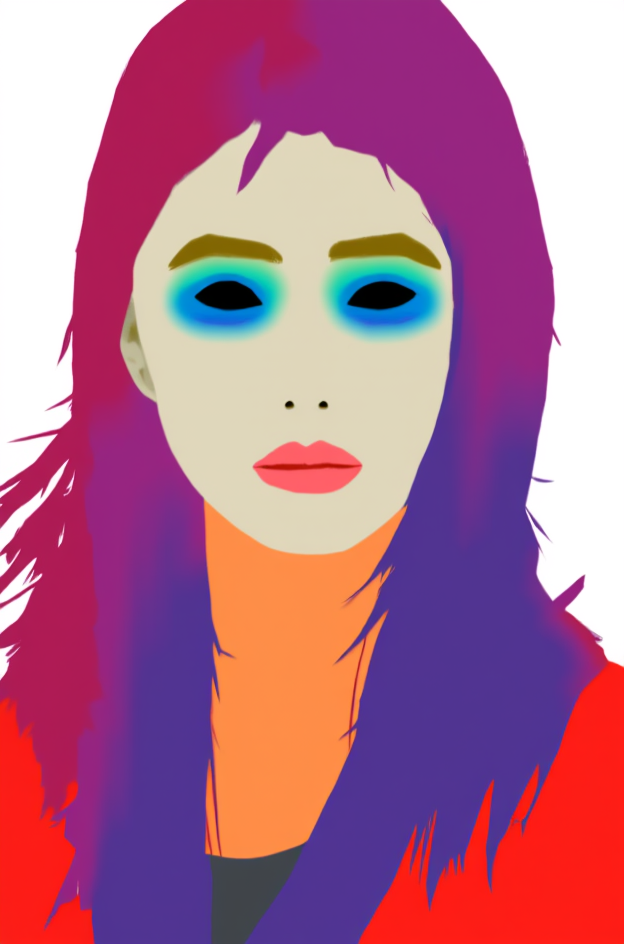

In [18]:
out[0]

## 1.2 Multi Control

In [19]:
LORA_WEIGHT='/tmp/image_edit_lora/character_composition_fp16/characterCompositionFluxKontextFp16/v0/checkpoint-549-1100/model.safetensors'

config="../../tests/test_configs/test_example_fluxkontext_fp16_character_composition.yaml"
config = load_config_from_yaml(config)

config.model.lora.pretrained_weight = LORA_WEIGHT
trainer = FluxKontextLoraTrainer(config)


2025-09-17 17:42:51,957 | INFO | src.trainer.base_trainer: Batch Size: 16
2025-09-17 17:42:51,958 | INFO | src.trainer.base_trainer: Use Cache: True
2025-09-17 17:42:51,958 | INFO | root: ImageProcessor initialized with target_size: (384, 672)controls_size: [(384, 672), (512, 512)]


In [21]:
from PIL import Image

def pad_to_square(img: Image.Image, fill=None):
    """Pad to square without resizing; centered content.
    fill: background color.
          - For RGB: (r,g,b) e.g. (255,255,255)
          - For RGBA: (r,g,b,a) e.g. (255,255,255,0) to keep transparency
          - If None: auto-choose (transparent if RGBA, white otherwise)
    """
    w, h = img.size
    side = max(w, h)

    if img.mode == "RGBA":
        bg_color = (255, 255, 255, 0) if fill is None else fill
        background = Image.new("RGBA", (side, side), bg_color)
    else:
        bg_color = (255, 255, 255) if fill is None else fill
        # convert to RGB if palette/L, etc., so fill works as expected
        if img.mode not in ("RGB", "L"):
            img = img.convert("RGB")
        background = Image.new(background_mode := ("L" if img.mode == "L" else "RGB"),
                               (side, side), bg_color)

    offset = ((side - w) // 2, (side - h) // 2)
    background.paste(img, offset)
    return background



In [22]:
import requests
from io import BytesIO
from PIL import Image
control_1 = load_image('https://cdn.shopify.com/s/files/1/0705/5491/0959/files/100_dfdf593d-bc73-4bb5-8d23-9181d510f628_480x480.webp')

In [23]:
control_1.size

(480, 480)

In [26]:
import requests
from PIL import Image
from io import BytesIO

image_file="https://cdna.artstation.com/p/assets/images/images/027/134/318/large/pang-ying-ep03-scene-sc037.jpg?1590684056"
prompt_image = load_image(image_file).convert('RGB')

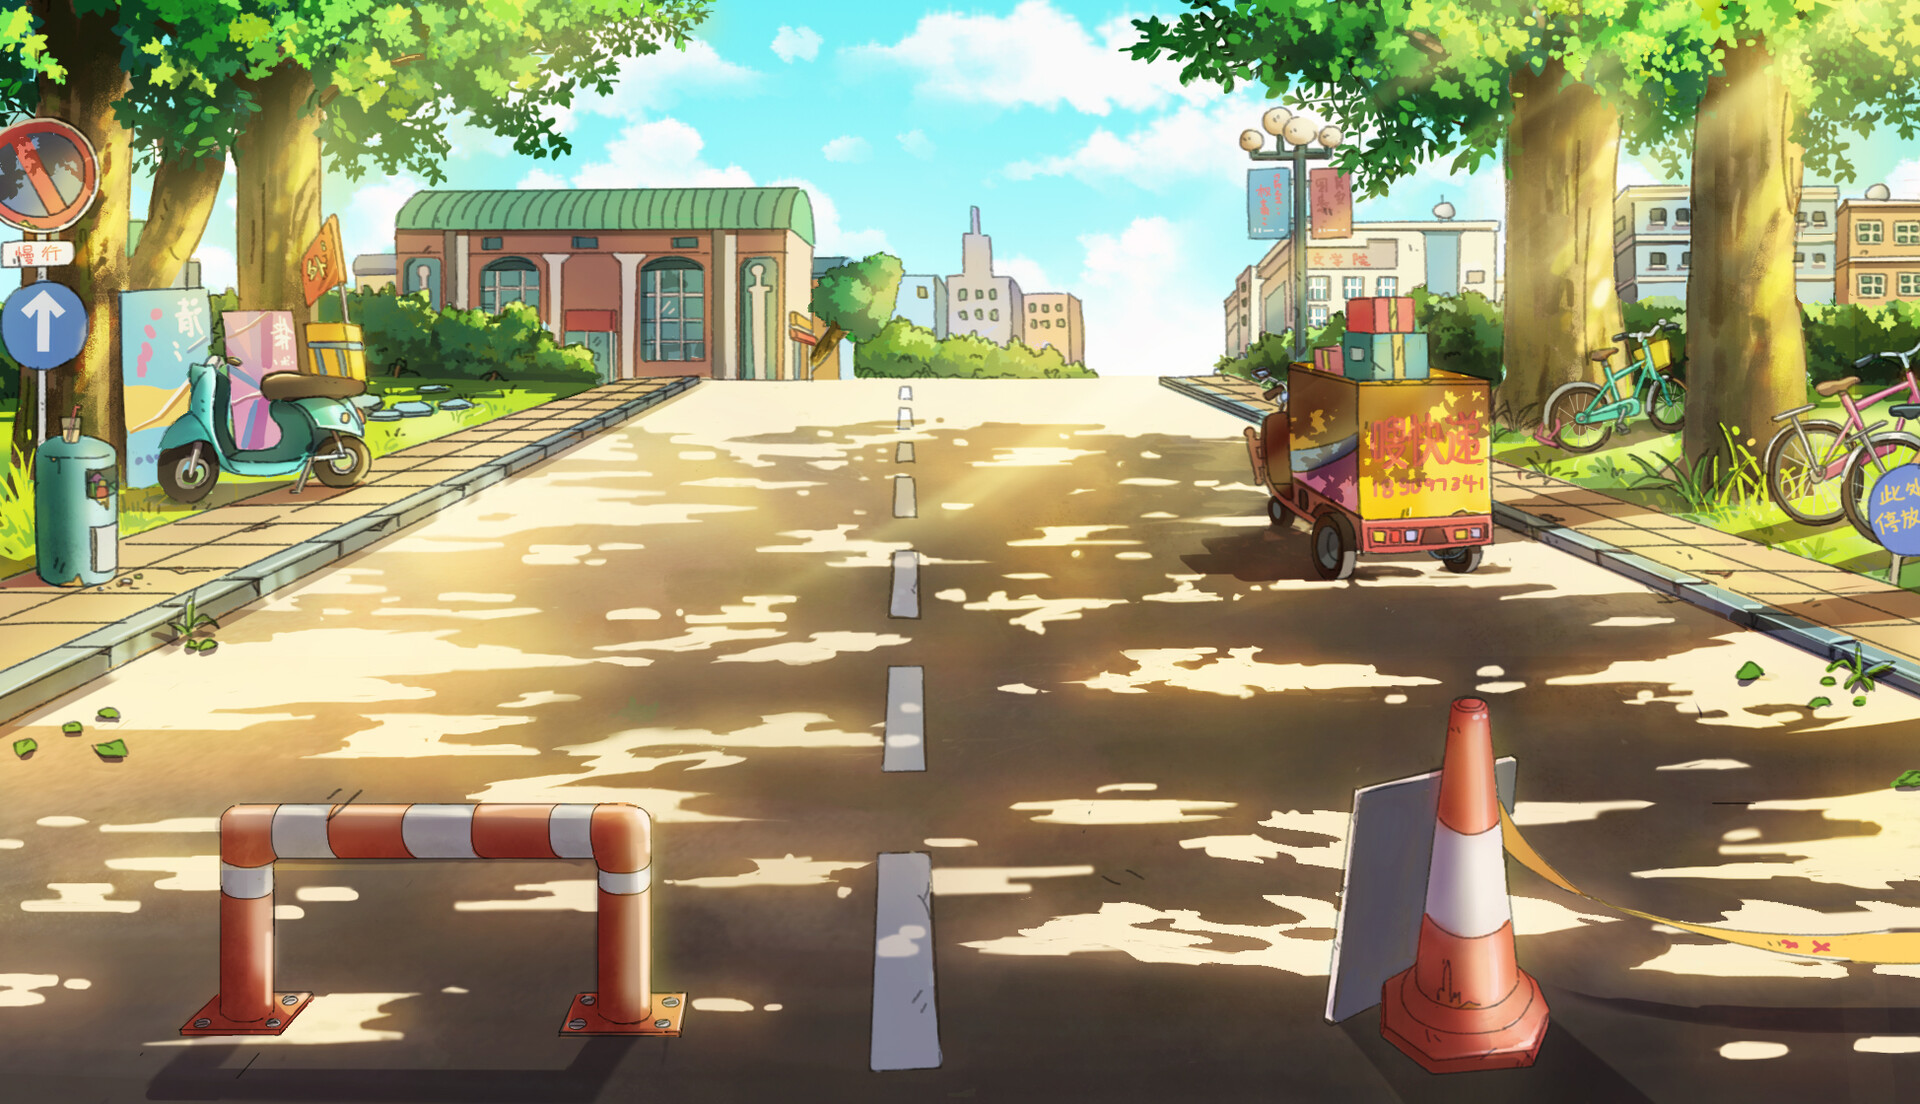

In [27]:
prompt_image

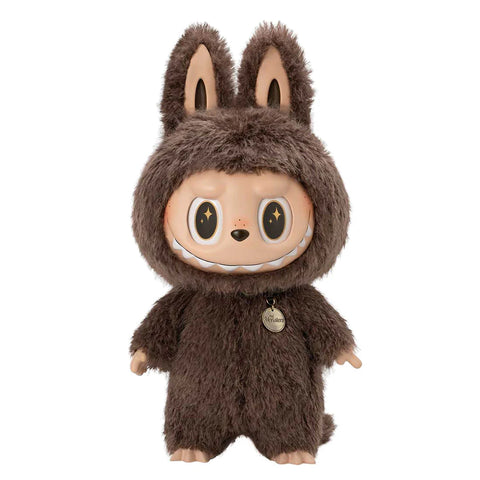

In [28]:
control_1

In [29]:
prompt

'change the image from the face to the face segmentation mask'

In [30]:
out = trainer.predict(
    prompt_image=prompt_image,
    prompt=prompt,
    num_inference_steps=20,
    true_cfg_scale=1.0,
    negative_prompt="",
    weight_dtype=torch.bfloat16,
    height=384,
    width=672,
    controls_size=[[384,672],[512,512]],
    additional_controls=[[control_1]],
    output_type='pil'
)
# save_path = 'tests/test_flux_kontext_trainer.png'
# save_path = os.path.abspath(save_path)

2025-09-17 17:44:18,175 | INFO | root: Loading model...
2025-09-17 17:44:18,177 | INFO | root: Loading FluxKontextPipeline and separating components...
2025-09-17 17:44:18,177 | INFO | src.models.flux_kontext_loader: Loading Flux Kontext VAE from black-forest-labs/FLUX.1-Kontext-dev
2025-09-17 17:44:19,035 | INFO | src.models.flux_kontext_loader: Loading Flux Kontext CLIP encoder from black-forest-labs/FLUX.1-Kontext-dev
2025-09-17 17:44:19,790 | INFO | src.models.flux_kontext_loader: Loading Flux Kontext T5 encoder from black-forest-labs/FLUX.1-Kontext-dev


Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00, 16.89it/s]


2025-09-17 17:44:21,644 | INFO | src.models.flux_kontext_loader: Loading Flux Kontext tokenizers from black-forest-labs/FLUX.1-Kontext-dev
2025-09-17 17:44:23,018 | INFO | src.models.flux_kontext_loader: Loading Flux Kontext scheduler from black-forest-labs/FLUX.1-Kontext-dev


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  8.19it/s]


2025-09-17 17:44:24,466 | INFO | src.models.flux_kontext_loader: Successfully loaded Flux Kontext scheduler
2025-09-17 17:44:24,472 | INFO | root: Components loaded successfully. VAE scale factor: 8
2025-09-17 17:44:24,472 | INFO | root: load lora from pretrained weight
2025-09-17 17:44:24,561 | INFO | root: add_lora_adapter: LoraConfig(task_type=None, peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, inference_mode=False, r=16, target_modules={'to_out.0', 'to_q', 'to_k', 'to_v'}, exclude_modules=None, lora_alpha=16, lora_dropout=0.0, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights='gaussian', layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', trainable_token_indices=None, loftq_config={}, eva_config=None, corda_config=None, use_dora=False, use_qalora=False, qalora_group_size=16, layer_replication=None, runtime

                                    Model Summary: model                                    
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Section     ┃ Metric                              ┃ Value                                ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Parameters  │ Total                               │ 11.92B                               │
│ Parameters  │ Trainable                           │ 0                                    │
│ Parameters  │ Trainable %                         │ 0.00%                                │
│ Parameters  │ Memory (total)                      │ 22.20 GB                             │
│ Parameters  │ Memory (trainable)                  │ 0 B                                  │
│ Modules     │ Total                               │ 3178                                 │
│ Modules     │ Leaf                                │ 2088                                 │
│ Modules     │ Parameterized                       │ 1036                                 │
│ Transformer │ Attention blocks (total/self/cross) │ 57/57/0                              │
│ Transformer │ Heads (hist)                        │ 24×57                                │
│ Transformer │ Attn hidden dim (hist)              │ 3072×57                              │
│ Transformer │ Norms                               │ LayerNorm×115, RMSNorm×152           │
│ Transformer │ FeedForward blocks                  │ 349                                  │
│ LoRA        │ Blocks                              │ 380                                  │
│ LoRA        │ Parameters                          │ 18.68M                               │
│ LoRA        │ Params % of total                   │ 0.16%                                │
│ LoRA        │ Ranks (hist)                        │ r=16×380                             │
│ LoRA        │ Rank min/max                        │ 16 / 16                              │
│ DTypes      │ dtype                               │ params(total/train) | % | mem(total) │
│ DTypes      │ bf16                                │ 11.92B/0 | 100.00% | 22.20 GB        │
└─────────────┴─────────────────────────────────────┴──────────────────────────────────────┘

2025-09-17 17:44:36,474 | INFO | root: setup_predict done
2025-09-17 17:44:36,474 | INFO | root: Start predict
2025-09-17 17:44:36,475 | INFO | root: image size format [H,W]
2025-09-17 17:44:36,480 | INFO | root: ##################################################
2025-09-17 17:44:36,480 | INFO | root: image shapes for controls: [[384, 672], [512, 512]]
2025-09-17 17:44:36,481 | INFO | root: image shape for target: [384, 672]
control_1 <class 'list'> <class 'torch.Tensor'> <class 'torch.Tensor'>
new controls torch.Size([1, 3, 512, 512]) control_1
data keys dict_keys(['control', 'prompt', 'control_1', 'n_controls', 'negative_prompt', 'num_inference_steps', 'height', 'width', 'true_cfg_scale', 'guidance'])
control <class 'torch.Tensor'>
prompt <class 'list'>
control_1 <class 'torch.Tensor'>
n_controls <class 'int'>
negative_prompt <class 'list'>
num_inference_steps <class 'int'>
height <class 'int'>
width <class 'int'>
true_cfg_scale <class 'float'>
guidance <class 'float'>
additional_con

Flux Kontext Generation: 100%|██████████| 20/20 [00:08<00:00,  2.36it/s]


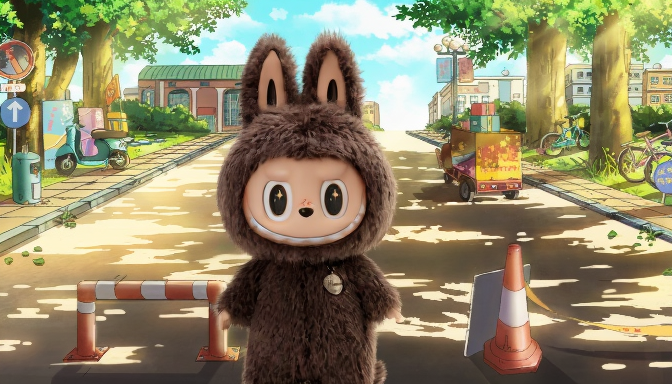

In [31]:
out[0]

In [33]:
out[0].size

(672, 384)